In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [3]:
n_clusters = 6
n_samples = 250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [4]:
centroids = torch.rand(n_clusters, 2) * 75 - 35

In [5]:
centroids

tensor([[ 31.170,  33.625],
        [ -6.285,  36.948],
        [ -5.716,  10.067],
        [-15.757,  24.523],
        [ 35.558, -25.011],
        [ 35.095,   9.518]])

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [7]:
def sample(m):
  return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [8]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [9]:
data[0]

tensor([30.615, 30.924])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [10]:
def plot_data(centroids, data, n_samples, ax=None):
  if ax is None:
    _, ax = plt.subplots()
  for i, centroid in enumerate(centroids):
    samples = data[i*n_samples: (i+1)*n_samples]
    ax.scatter(samples[:,0], samples[:,1], s=1)
    ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)
    ax.plot(*centroid, markersize=5, marker='o', color='b', mew=2)

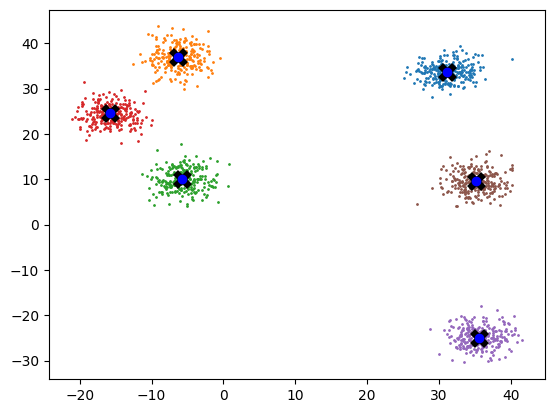

In [11]:
plot_data(centroids, data, n_samples)

## Mean shift

In [12]:
midp = data.mean(0)
midp

tensor([12.378, 14.934])

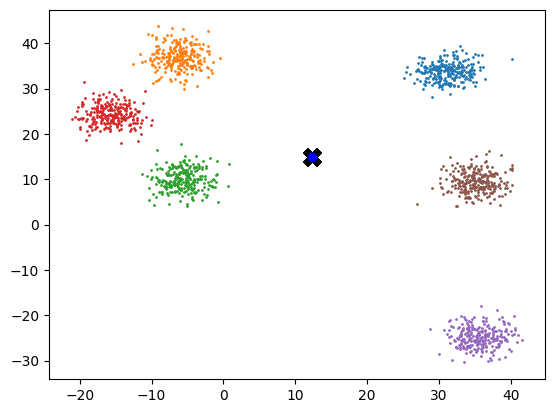

In [13]:
plot_data([midp]*6, data, n_samples)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In [14]:
def gaussian(d, bw):
  return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [15]:
def plot_func(f):
  x = torch.linspace(0, 10, 100)
  plt.plot(x, f(x))

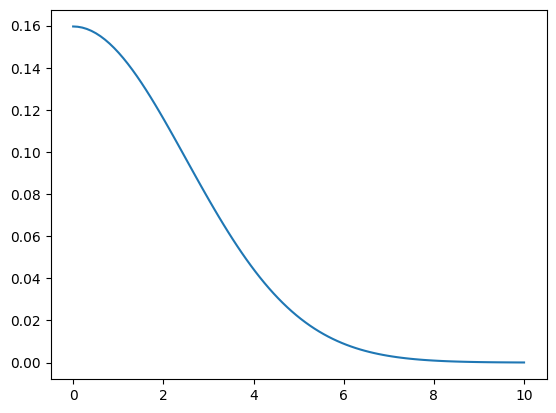

In [16]:
plot_func(partial(gaussian, bw=2.5))

In our implementation, we choose the bandwidth to be 2.5.

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [17]:
def tri(d, i):
  return (-d+i).clamp_min(0)/i

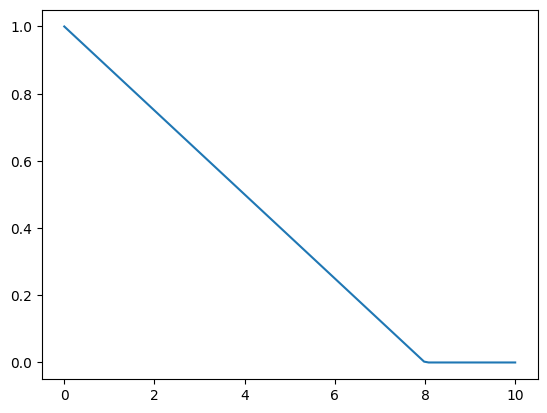

In [18]:
plot_func(partial(tri, i=8))

In [19]:
X = data.clone()
x = data[0]

In [20]:
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [21]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [22]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [23]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [24]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [25]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [26]:
weight[:,None]*X

tensor([[    4.885,     4.935],
        [    1.424,     1.646],
        [    0.857,     0.819],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [27]:
def one_update(X):
  for i, x in enumerate(X):
    dist = torch.sqrt(((x-X)**2).sum(1))
    # weight = gaussian(dist, 2.5)
    weight = tri(dist, 8)
    X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [28]:
def meanshift(X):
  X = data.clone()
  for it in range(5):
    one_update(X)
  return X

In [29]:
%time X=meanshift(data)

CPU times: user 928 ms, sys: 2.96 ms, total: 931 ms
Wall time: 956 ms


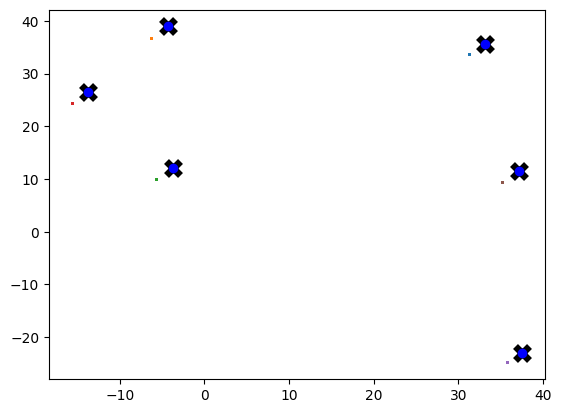

In [30]:
plot_data(centroids+2, X, n_samples)

## Animation

In [31]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [32]:
def do_one(d):
    if d:
      one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [33]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [34]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [35]:
def dist_b(a,b):
  return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [36]:
dist_b(X, x)

tensor([[ 0.000,  3.899,  4.834,  ..., 19.248, 24.237, 23.242],
        [ 3.899,  0.000,  4.978,  ..., 23.123, 28.136, 27.126],
        [ 4.834,  4.978,  0.000,  ..., 20.986, 26.353, 25.012],
        [ 3.726,  0.185,  4.969,  ..., 22.958, 27.964, 26.959],
        [ 6.273,  5.547,  1.615,  ..., 22.378, 27.788, 26.392]])

In [37]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [38]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [39]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [40]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [41]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [42]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [43]:
num

tensor([[429.396, 450.040],
        [605.937, 679.535],
        [379.999, 382.983],
        [616.894, 690.807],
        [266.098, 270.242]])

In [44]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[429.396, 450.040],
        [605.937, 679.535],
        [379.999, 382.983],
        [616.894, 690.807],
        [266.098, 270.242]])

In [45]:
weight@X

tensor([[429.396, 450.040],
        [605.937, 679.535],
        [379.999, 382.983],
        [616.894, 690.807],
        [266.098, 270.242]])

In [46]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [47]:
num/div

tensor([[30.787, 32.267],
        [30.512, 34.218],
        [33.304, 33.565],
        [30.482, 34.134],
        [33.735, 34.260]])

In [48]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

In [49]:
data = data.cuda()

In [50]:
X = meanshift(data).cpu()

In [51]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

5.85 ms ± 416 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


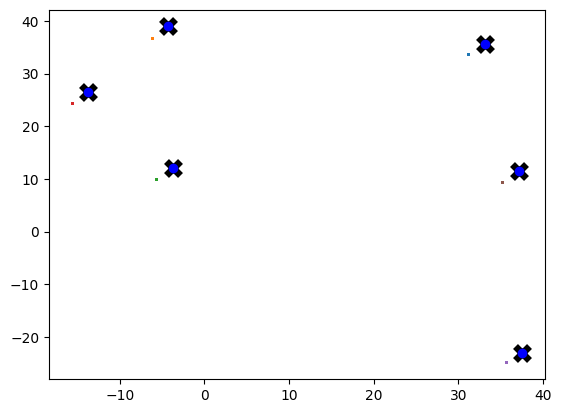

In [52]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D